In [ ]:
'''
Panagiotis Christakakis
'''

# **Problem 1 - Studying Real Networks**

## Libraries

In [1]:
# Import Libraries
import numpy as np
import networkx as nx
import itertools as it
from networkx.algorithms import community as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from scipy.special import binom

## Functions

In [2]:
# Define the functions needed for the code

def calculate_nmi(groundTruthZeros, communitiesFound):
  '''
  This function calculates the Normalized Mutual Information Score base on 
  https://course.ccs.neu.edu/cs6140sp15/7_locality_cluster/Assignment-6/NMI.pdf
  For the implementation of this function I cooperated with Christos Papadopoulos (aid23002)
  '''

  import math

  countAll = 0
  countZero = 0
  countOne = 0

  # Entropy of Class Labels
  for community in communitiesFound:
    for i in community:
      if i in groundTruthZeros:
          countZero += 1
          countAll += 1
      else:
          countOne += 1
          countAll += 1
  p0 = countZero / countAll
  p1 = countOne / countAll
  h_y = - (p0 * math.log2(p0)) - (p1 * math.log2(p1))

  # Entropy of Cluster Labels
  h_c = 0
  for community in communitiesFound:
    lenght = len(community)
    prob = lenght / countAll
    h_c -= prob * math.log2(prob)

  # Mutual Information
  h_y_c = 0
  for community in communitiesFound:
    count_Zero = 0
    count_One = 0
    count_All = 0

    for i in community:
      if i in groundTruthZeros:
          count_Zero += 1
          count_All += 1
      else:
          count_One += 1
          count_All += 1
    prob0 = count_Zero / count_All
    prob1 = count_One / count_All
    prob_communities = count_All / countAll
    # print(prob0, prob1, prob_communities)
    if prob0 != 0:
      h_y_c -= prob_communities * (prob0 * math.log2(prob0))
    if prob1 != 0:
      h_y_c -= prob_communities * (prob1 * math.log2(prob1))

  i_y_c = h_y - h_y_c
  nmi = (2 * i_y_c) / (h_y + h_c)
  return nmi

# ------------------------------------------------------#

def girvan_newman(G):
    """ run the algorithm of Girvan + Newman up to the first separation
        and return list of components of G, list of edges removed
    """
    
    # we're going to remove edges, so do it on a copy of the original graph
    G = G.copy()
    
    def find_best_edge(G0):
        """ get the edge from G0 with highest betweenness centrality"""
        eb = nx.edge_betweenness_centrality(G0)
        edges = eb.keys()
        return max(edges, key=lambda e: eb[e])

    removed_edges = []
    # Proceed until we separate the graph
    while nx.number_connected_components(G) == 1:
        u, v = find_best_edge(G)
        G.remove_edge(u, v)
        removed_edges.append((u, v))

    return list(nx.connected_components(G)), removed_edges

# ------------------------------------------------------#

def tp(groundTruthCommOfZeros,communities):
  from scipy.special import binom

  max_label=[]
  for community in communities:
    count0=0
    count1=0
    for i in community:
        if i in groundTruthCommOfZeros:
          count0 +=1
        else:
          count1 +=1
    max_label.append(max(count0,count1))
  true_positives = binom(2,2)
  for i in range(len(communities)):
    true_positives += binom(max_label[i],2)
  return true_positives
 
# ------------------------------------------------------#

def fp(groundTruthCommOfZeros,communities):
  false_positives = 0
  for community in communities:
    count0=0
    count1=0
    for i in community:
       if i in groundTruthCommOfZeros:
         count0 +=1
       else:
         count1 +=1
    false_positives += count0*count1 
  return false_positives

# ------------------------------------------------------#

def sum_of_products(numbers): # i need this for the function that calculates the false negatives
  """Returns the sum of each number multiplied with every other number"""
  result = 0
  for i in range(len(numbers)):
      for j in range(i + 1, len(numbers)):
          result += numbers[i] * numbers[j]
  return result

# ------------------------------------------------------#

def fn(groundTruthCommOfZeros,communities):
  counter0=[]
  counter1=[]
  for community in communities:
    count0=0
    count1=0
    for i in community:
      if i in groundTruthCommOfZeros:
         count0 +=1
      else:
         count1 +=1
    counter0.append(count0)
    counter1.append(count1)
  false_negatives = (sum_of_products(counter0)+sum_of_products(counter1))
  return false_negatives

# ------------------------------------------------------#

def tn(groundTruthCommOfZeros,communities):
  counter0=[]
  counter1=[]
  for community in communities:
    count0=0
    count1=0
    for i in community:
      if i in groundTruthCommOfZeros:
         count0 +=1
      else:
         count1 +=1
    counter0.append(count0)
    counter1.append(count1)
  true_negatives=0
  # loop through each element in the list
  for i in range(len(communities)):
      for j in range(len(communities[i])):
          product = communities[i][j]
          # multiply the element with all other elements not on the same row and column
          for x in range(len(communities)):
              for y in range(len(communities[x])):
                  if x != i and y != j and x>i:
                      true_negatives += product * communities[x][y]
  return true_negatives

# ------------------------------------------------------#

def purity(groundTruthCommOfZeros,groundTruthCommOfOnes,clusters):
  max_cluster=[]
  for community in clusters:
    count0=0
    count1=0
    for i in community:
      if i in groundTruthCommOfZeros:
        count0+=1
      else:
        count1+=1
    max_cluster.append(max(count0,count1))
  summ= sum(max_cluster)
  pur= summ/(len(groundTruthCommOfZeros)+len(groundTruthCommOfOnes))
  return pur

# ------------------------------------------------------#

def precision(groundTruthZeros,calculatedComms):
  '''
  This function calculates the Precision Score base on
  https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
  For the implementation of this function and the functions which calculate the
  TP, FP, TN, FN  I cooperated with Christos Papadopoulos (aid23002)
  Manos Nikitas (aid23012), Georgia Kesesidou (aid23010)
  '''
  true_positives = tp(groundTruthZeros, calculatedComms)
  false_positives = fp(groundTruthZeros, calculatedComms)
  return true_positives / (true_positives + false_positives)

# ------------------------------------------------------#

def recall(groundTruthZeros,calculatedComms):
  '''
  This function calculates the Recall Score base on 
  https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
  For the implementation of this function and the functions which calculate the
  TP, FP, TN, FN  I cooperated with Christos Papadopoulos (aid23002)
  Manos Nikitas (aid23012), Georgia Kesesidou (aid23010)
  '''
  true_positives = tp(groundTruthZeros, calculatedComms)
  false_negatives = fn(groundTruthZeros, calculatedComms)
  return true_positives / (true_positives + false_negatives)

# ------------------------------------------------------#

def min_conductance(communities, graph):
  '''
  This function calculates the Conductance 
  For the implementation of this function I cooperated with Christos Papadopoulos (aid23002),
  Manos Nikitas (aid23012), Georgia Kesesidou (aid23010)
  '''
  min_cond = float("inf")
  for comm in communities:
      cut_size = nx.algorithms.cuts.cut_size(graph, comm)
      volume = sum(graph.degree[node] for node in comm)
      complement_volume = sum(graph.degree[node] for node in graph.nodes() if node not in comm)
      if min(volume, complement_volume) != 0:
        conductance = cut_size / min(volume, complement_volume)
        if conductance < min_cond:
            min_cond = conductance
      else:
        min_cond = 0
  return min_cond

# ------------------------------------------------------#

def density(communities, graph):
  '''
  This function calculates the Density 
  For the implementation of this function I cooperated with Christos Papadopoulos (aid23002),
  Manos Nikitas (aid23012), Georgia Kesesidou (aid23010)
  '''
  densities = []
  for community in communities:
      subgraph = graph.subgraph(community)
      m = subgraph.number_of_edges()
      n = subgraph.number_of_nodes()
      if n <= 1:
          densities.append(0.0)
      else:
          densities.append((2 * m) / (n * (n - 1)))
  return sum(densities) / len(densities)

## Pre-processing

In [3]:
G = nx.read_gml("polblogs.gml")

In [4]:
G_1 = nx.Graph(G)

Keeping a subgraph of the strongly connected components.

In [5]:
# We store a subgraph of the strongly connected components for easier calculations
strongComp = max(nx.strongly_connected_components(G), key=len)
strongCompSubGraph = G.subgraph(strongComp)

In [6]:
print("Starting polblogs.gml Graph is size of:", len(G.nodes()), "nodes, and", len(G.edges()), "total edges.")
print("The final subgraph of strongly connected component is size of:", len(strongCompSubGraph.nodes()), "nodes, and", len(strongCompSubGraph.edges()), "total edges.")

Starting polblogs.gml Graph is size of: 1490 nodes, and 19090 total edges.
The final subgraph of strongly connected component is size of: 793 nodes, and 15841 total edges.


In [7]:
# Create an undirected graph cause it will be needed for later
undirectedSubgraph = strongCompSubGraph.to_undirected()

In [8]:
G1 = nx.Graph(undirectedSubgraph)

## Visualization of Ground Truth Communities

Total lenght of ground truth is:  793


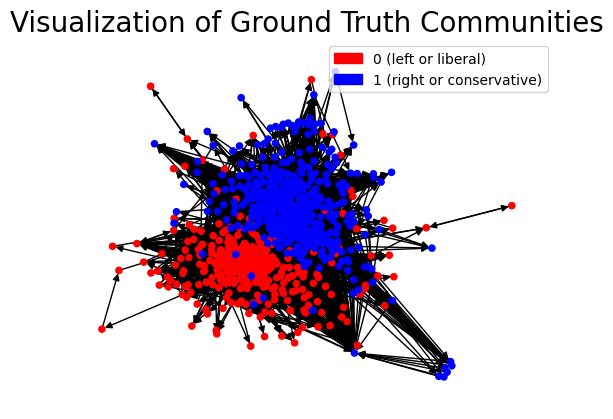

In [9]:
# Obtain the ground truth community of the graph based on the
# value of each node and add it to a list for easier computations.
ground_truth = nx.get_node_attributes(strongCompSubGraph, 'value')
ground_truth_values = list(ground_truth.values())
print("Total lenght of ground truth is: ", len(ground_truth.values()))

# For visualization purposes we append a different color
# for each node value for the two different political 
# beliefs. So for 0 (left or liberal) we give red color
# and for 1 (right or conservative) we give blue color nodes.
color_map = []
for v in ground_truth_values:
    if v == 0:
        color_map.append("red")
    else:
        color_map.append("blue")

# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(strongCompSubGraph)

# Visualize ground truth community
plt.title("Visualization of Ground Truth Communities", fontsize=20)
# Legend
red_patch = mpatches.Patch(color='red', label='0 (left or liberal)')
blue_patch = mpatches.Patch(color='blue', label='1 (right or conservative)')
plt.legend(handles=[red_patch, blue_patch], loc="upper right")
# Draw edges and nodes based on calculated pos
nx.draw(strongCompSubGraph, pos, node_color = color_map, node_size = 20)
nx.draw_networkx_edges(strongCompSubGraph, pos, alpha = 0.005)
plt.show()

In [10]:
# Sort the nodes of the graph into separate lists based on their "value" attribute
# (0 or 1) in order to have ground truth communities as separate lists.
# We will need those for later use, in order to calculate the metrics.
groundTruthComm_0 = [node for node, value in ground_truth.items() if value == 0]
groundTruthComm_1 = [node for node, value in ground_truth.items() if value == 1]

In [11]:
# Create a list that includes the entire ground truth in order
# to be able to calculate metrics for the ground truth. 
groundTruthList = []
groundTruthList.append(groundTruthComm_0)
groundTruthList.append(groundTruthComm_1)

## A) Cliques

In [12]:
# (A) Clique Communities
# Becuase of computational limitations and limited resources a high value
# of cliques is selected. Otherwise k_clique_communities function was 
# taking far too long to calculate the desired outcome. 
communities_A = list(nx.community.k_clique_communities(undirectedSubgraph, 18))
print("This method found:", len(communities_A), "communities.")

This method found: 1 communities.


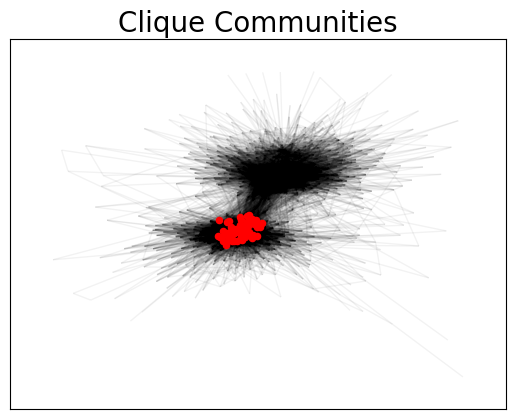

In [13]:
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(undirectedSubgraph)

# Create a color and shapes pallet for different communities
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'yellow', 'silver', 'gold']
# Draw edges and nodes based on calculated pos
count = 0
for community in communities_A:
    nx.draw_networkx_nodes(undirectedSubgraph, pos, community, node_size = 20, node_color = colors[count])
    count += 1
nx.draw_networkx_edges(undirectedSubgraph, pos, alpha=0.05)
# Visualize ground truth community
plt.title("Clique Communities", fontsize=20)
plt.show()

## B) Modularity Maximazation

In [14]:
# (B) Modularity Maximization Communities
communities_B = cm.greedy_modularity_communities(strongCompSubGraph)
print("This method found:", len(communities_B), "communities.")

This method found: 6 communities.


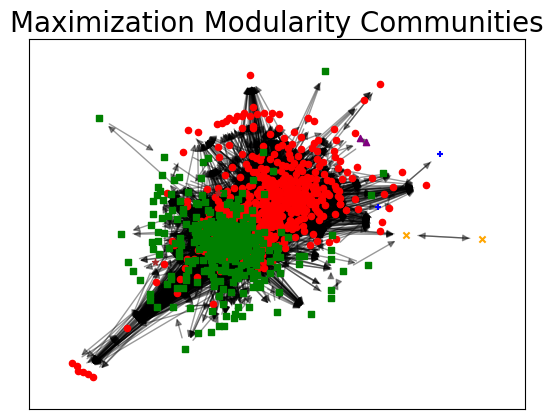

In [15]:
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos=nx.spring_layout(strongCompSubGraph)

# Create a color and shapes pallet for different communities
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'yellow', 'silver', 'gold']
shapes = ['o', 's', '+', 'x', '^', '*', 'h']
# Draw edges and nodes based on calculated pos
count = 0
for community in communities_B:
    nx.draw_networkx_nodes(strongCompSubGraph, pos, community, node_size = 20, node_color = colors[count], node_shape=shapes[count])
    count += 1
nx.draw_networkx_edges(strongCompSubGraph, pos, alpha=0.4)
# Visualize ground truth community
plt.title("Maximization Modularity Communities", fontsize=20)
plt.show()

## C) Agglomerative

In [16]:
# (E) Agglomerative Hierarchical Communities

# Conversion of the graph to numpy array (1) and 
# apply agglomerative clustering to the array (2)

graphToArrayAgglomerative = nx.to_numpy_array(undirectedSubgraph)  #(1)
numOfClusters = 2 #Here we set the num of clusters we want
agglomerativeClustered = AgglomerativeClustering(n_clusters = numOfClusters, affinity = 'euclidean', linkage = 'ward') #(2)
labelsProducedAgglomerative = agglomerativeClustered.fit_predict(graphToArrayAgglomerative)

# Creating the final list of Agglomerative Communities
clustering_nodes_agglomerative = {}
for node, label in zip(undirectedSubgraph.nodes(), labelsProducedAgglomerative):
  clustering_nodes_agglomerative[node] = label

communities_C = [[] for _ in range(numOfClusters)]
for node, cluster in clustering_nodes_agglomerative.items():
  communities_C[cluster].append(node)

print("This method found:", len(communities_C), "communities.")

This method found: 2 communities.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


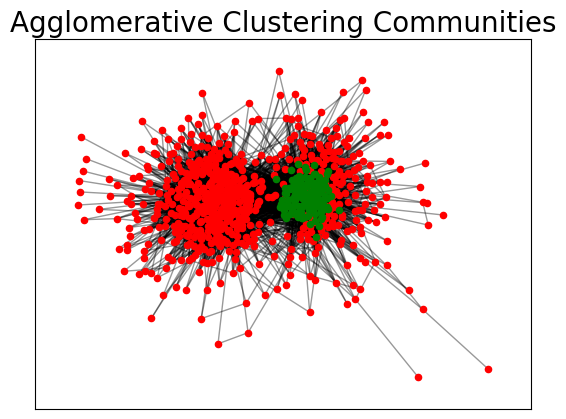

In [17]:
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(undirectedSubgraph)

# Create a color and shapes pallet for different communities
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'yellow', 'silver', 'gold']
# Draw edges and nodes based on calculated pos
count = 0
for community in communities_C:
    nx.draw_networkx_nodes(undirectedSubgraph, pos, community, node_size = 20, node_color = colors[count])
    count += 1
nx.draw_networkx_edges(undirectedSubgraph, pos, alpha=0.4)
# Visualize ground truth community
plt.title("Agglomerative Clustering Communities", fontsize=20)
plt.show()

## D) Hierarchical Clustering - Girvan Newman

In [18]:
# (D) Hierarchical - Girvan-Newman Communities
communities_D, removed_edges_D = girvan_newman(G1)
print("This method found:", len(communities_D), "communities.")

This method found: 2 communities.


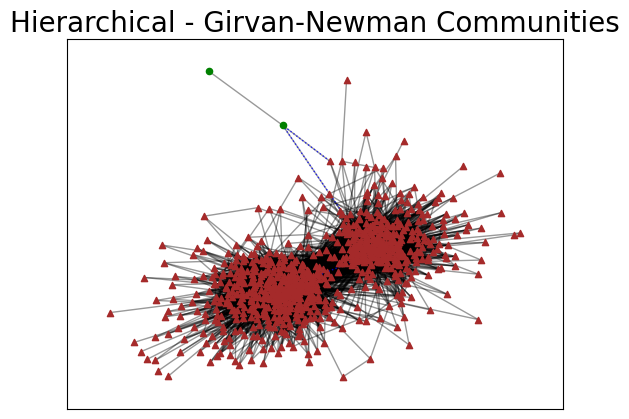

In [19]:
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(undirectedSubgraph)

# Create a color and shapes pallet for different communities
colors = ['brown', 'green', 'blue', 'orange', 'purple', 'cyan', 'red', 'yellow', 'silver', 'gold']
shapes = ['^', 'o', 's', 'x', '+', '*', 'h']
# Draw edges and nodes based on calculated pos
count = 0
for community in communities_D:
    nx.draw_networkx_nodes(undirectedSubgraph, pos, community, node_size = 20, node_color = colors[count], node_shape=shapes[count])
    count += 1
nx.draw_networkx_edges(undirectedSubgraph, pos, alpha = 0.4)
nx.draw_networkx_edges(undirectedSubgraph, pos, edgelist = removed_edges_D, style = "dotted", edge_color="blue", alpha=0.8)
# Visualize ground truth community
plt.title("Hierarchical - Girvan-Newman Communities", fontsize=20)
plt.show()

## E) Spectral Clustering

In [20]:
# (E) Spectral Clustering Communities
communities_E = list(cm.label_propagation_communities(undirectedSubgraph))
print("This method found:", len(communities_E), "communities.")

This method found: 4 communities.


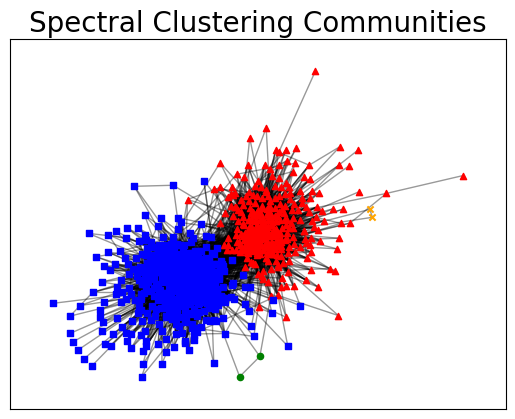

In [21]:
# Position nodes using Fruchterman-Reingold force-directed algorithm.
pos = nx.spring_layout(undirectedSubgraph)

# Create a color and shapes pallet for different communities
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'yellow', 'silver', 'gold']
shapes = ['^', 'o', 's', 'x', '+', '*', 'h']
# Draw edges and nodes based on calculated pos
count = 0
for community in communities_E:
    nx.draw_networkx_nodes(undirectedSubgraph, pos, community, node_size = 20, node_color = colors[count], node_shape=shapes[count])
    count += 1
nx.draw_networkx_edges(undirectedSubgraph, pos, alpha = 0.4)
# Visualize ground truth community
plt.title("Spectral Clustering Communities", fontsize = 20)
plt.show()

## **Results**

In [22]:
# Metrics for Ground Truth Communities
print("Printing Metrics for Ground Truth Communities \n=======================")

modularity_GT = nx.algorithms.community.modularity(G1, groundTruthList)
print("Modularity is:", "{:.4f}".format(modularity_GT))

conductance_GT = min_conductance(groundTruthList, G1)
print("Conductance is:", "{:.4f}".format(conductance_GT))

density_GT = density(groundTruthList, G1)
print("Density is:", "{:.4f}".format(density_GT))

Printing Metrics for Ground Truth Communities 
Modularity is: 0.4151
Conductance is: 0.0875
Density is: 0.0812


In [23]:
# Metrics for (A) Cliques
print("Printing Metrics for (A) Cliques \n=======================")

precision_A = precision(groundTruthComm_0,communities_A)
print("Precision is:", "{:.4f}".format(precision_A))

recall_A = recall(groundTruthComm_0,communities_A)
print("Recall is:", "{:.4f}".format(recall_A))

purity_A = purity(groundTruthComm_0, groundTruthComm_1, communities_A)
print("Purity is:", "{:.4f}".format(purity_A))

try:
  nmi_A = calculate_nmi(groundTruthComm_0,communities_A)
  print("NMI is:", "{:.4f}".format(nmi_A))
except:
  print("Cannot calculate NMI for Cliques Finding method.")

if (nx.algorithms.community.is_partition(undirectedSubgraph, communities_A)) == False:
  print("Cannot calculate Modularity because given Graph and detected clique communities don't form a valid partition")
else:
  modularity_A = nx.algorithms.community.modularity(undirectedSubgraph, communities_A)
  print("Modularity is:", "{:.4f}".format(modularity_A))

conductance_A = min_conductance(communities_A, undirectedSubgraph)
print("Conductance is:", "{:.4f}".format(conductance_A))

density_A = density(communities_A, undirectedSubgraph)
print("Density is:", "{:.4f}".format(density_A))

Printing Metrics for (A) Cliques 
Precision is: 1.0000
Recall is: 1.0000
Purity is: 0.0694
Cannot calculate NMI for Cliques Finding method.
Cannot calculate Modularity because given Graph and detected clique communities don't form a valid partition
Conductance is: 0.5977
Density is: 0.7771


In [24]:
# Metrics for (B) Modularity Maximization
print("Printing Metrics for (B) Modularity Maximazation \n=======================")

precision_B = precision(groundTruthComm_0,communities_B)
print("Precision is:", "{:.4f}".format(precision_B))

recall_B = recall(groundTruthComm_0,communities_B)
print("Recall is:", "{:.4f}".format(recall_B))

purity_B = purity(groundTruthComm_0, groundTruthComm_1, communities_B)
print("Purity is:", "{:.4f}".format(purity_B))

nmi_B = calculate_nmi(groundTruthComm_0,communities_B)
print("NMI is:", "{:.4f}".format(nmi_B))

modularity_B = nx.algorithms.community.modularity(strongCompSubGraph, communities_B)
print("Modularity is:", "{:.4f}".format(modularity_B))

conductance_B = min_conductance(communities_B, G1)
print("Conductance is:", "{:.4f}".format(conductance_B))

density_B = density(communities_B, G1)
print("Density is:", "{:.4f}".format(density_B))

Printing Metrics for (B) Modularity Maximazation 
Precision is: 0.9384
Recall is: 0.9271
Purity is: 0.9697
NMI is: 0.7713
Modularity is: 0.4391
Conductance is: 0.0692
Density is: 0.6953


In [25]:
# Metrics for (C) Agglomerative
print("Printing Metrics for (C) Agglomerative \n=======================")

precision_C = precision(groundTruthComm_0,communities_C)
print("Precision is:", "{:.4f}".format(precision_C))

recall_C = recall(groundTruthComm_0,communities_C)
print("Recall is:", "{:.4f}".format(recall_C))

purity_C = purity(groundTruthComm_0, groundTruthComm_1, communities_C)
print("Purity is:", "{:.4f}".format(purity_C))

nmi_C = calculate_nmi(groundTruthComm_0,communities_C)
print("NMI is:", "{:.4f}".format(nmi_C))

modularity_C = nx.algorithms.community.modularity(strongCompSubGraph, communities_C)
print("Modularity is:", "{:.4f}".format(modularity_C))

conductance_C = min_conductance(communities_C, G1)
print("Conductance is:", "{:.4f}".format(conductance_C))

density_C = density(communities_C, G1)
print("Density is:", "{:.4f}".format(density_C))

Printing Metrics for (C) Agglomerative 
Precision is: 0.5280
Recall is: 0.7816
Purity is: 0.7276
NMI is: 0.2717
Modularity is: 0.2808
Conductance is: 0.2695
Density is: 0.2112


In [26]:
# Metrics for (D) Hierarchical Clustering - Girvan Newman
print("Printing Metrics for (D) Hierarchical Clustering - Girvan Newman \n=======================")

precision_D = precision(groundTruthComm_0,communities_D)
print("Precision is:", "{:.4f}".format(precision_D))

recall_D = recall(groundTruthComm_0,communities_D)
print("Recall is:", "{:.4f}".format(recall_D))

purity_D = purity(groundTruthComm_0, groundTruthComm_1, communities_D)
print("Purity is:", "{:.4f}".format(purity_D))

nmi_D = calculate_nmi(groundTruthComm_0,communities_D)
print("NMI is:", "{:.4f}".format(nmi_D))

modularity_D = nx.algorithms.community.modularity(strongCompSubGraph, communities_D)
print("Modularity is:", "{:.4f}".format(modularity_D))

conductance_D = min_conductance(communities_D, G1)
print("Conductance is:", "{:.4f}".format(conductance_D))

density_D = density(communities_D, G1)
print("Density is:", "{:.4f}".format(density_D))

Printing Metrics for (D) Hierarchical Clustering - Girvan Newman 
Precision is: 0.3872
Recall is: 0.9929
Purity is: 0.5599
NMI is: 0.0058
Modularity is: 0.0003
Conductance is: 0.5000
Density is: 0.5216


In [27]:
# Metrics for (Ε) Spectral Clustering
print("Printing Metrics for (Ε) Spectral Clustering \n=======================")

precision_E = precision(groundTruthComm_0,communities_E)
print("Precision is:", "{:.4f}".format(precision_E))

recall_E = recall(groundTruthComm_0,communities_E)
print("Recall is:", "{:.4f}".format(recall_E))

purity_E = purity(groundTruthComm_0, groundTruthComm_1, communities_E)
print("Purity is:", "{:.4f}".format(purity_E))

nmi_E = calculate_nmi(groundTruthComm_0,communities_E)
print("NMI is:", "{:.4f}".format(nmi_E))

modularity_E = nx.algorithms.community.modularity(strongCompSubGraph, communities_E)
print("Modularity is:", "{:.4f}".format(modularity_E))

conductance_E = min_conductance(communities_E, G1)
print("Conductance is:", "{:.4f}".format(conductance_E))

density_E = density(communities_E, G1)
print("Density is:", "{:.4f}".format(density_E))

Printing Metrics for (Ε) Spectral Clustering 
Precision is: 0.9361
Recall is: 0.9347
Purity is: 0.9685
NMI is: 0.7829
Modularity is: 0.4388
Conductance is: 0.0689
Density is: 0.5426


# **Problem 2 - Production of Synthetic Networks**

## Creating the synthetic graphs

In [ ]:
''' used:
https://networkx.org/documentation/stable/reference/generated
/networkx.generators.random_graphs.powerlaw_cluster_graph.html
'''
# n represents the number of nodes
# m represents the number of random edges to add for each new node
# p represents the probability of adding a triangle after adding a random edge

# In order to examine also the effect of m we create 
# 3 triplet graphs with same m but different p.

n = 1500
p1 = 0.1
p2 = 0.45
p3 = 0.95

# First triplet of graphs that have m set as 2.
m1 = 2
graph_A1 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m1, p1)
graph_A2 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m1, p2)
graph_A3 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m1, p3)

# Second triplet of graphs that have m set as 4.
m2 = 4
graph_B1 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m2, p1)
graph_B2 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m2, p2)
graph_B3 = nx.generators.random_graphs.powerlaw_cluster_graph(n, m2, p3)

## Modularity Maximazation and Spectral Clustering Communities For Synthetic Networks

In [ ]:
# Calculation of (B) Modularity Maximazation and 
# (E) Spectral Clustering Communities for the 
# graph_A-s with m = 2.

modCommunities_A1 = cm.greedy_modularity_communities(graph_A1)
spCommunities_A1 = list(cm.label_propagation_communities(graph_A1))
print("For", n, "nodes, m =", m1, "p =", p1, "we have.")
print("Modularity Maximazation found:", len(modCommunities_A1), "communities.")
print("Spectral Clustering found:", len(spCommunities_A1), "communities.\n")

modCommunities_A2 = cm.greedy_modularity_communities(graph_A2)
spCommunities_A2 = list(cm.label_propagation_communities(graph_A2))
print("For", n, "nodes, m =", m1, "p =", p2, "we have.")
print("Modularity Maximazation found:", len(modCommunities_A2), "communities.")
print("Spectral Clustering found:", len(spCommunities_A2), "communities.\n")

modCommunities_A3 = cm.greedy_modularity_communities(graph_A3)
spCommunities_A3 = list(cm.label_propagation_communities(graph_A3))
print("For", n, "nodes, m =", m1, "p =", p3, "we have.")
print("Modularity Maximazation found:", len(modCommunities_A3), "communities.")
print("Spectral Clustering found:", len(spCommunities_A3), "communities.\n")

For 1500 nodes, m = 2 p = 0.1 we have.
Modularity Maximazation found: 23 communities.
Spectral Clustering found: 400 communities.

For 1500 nodes, m = 2 p = 0.45 we have.
Modularity Maximazation found: 26 communities.
Spectral Clustering found: 305 communities.

For 1500 nodes, m = 2 p = 0.95 we have.
Modularity Maximazation found: 22 communities.
Spectral Clustering found: 242 communities.



In [ ]:
# Calculation of (B) Modularity Maximazation and 
# (E) Spectral Clustering Communities for the 
# graph_B-s with m = 4.

modCommunities_B1 = cm.greedy_modularity_communities(graph_B1)
spCommunities_B1 = list(cm.label_propagation_communities(graph_B1))
print("For", n, "nodes, m =", m2, "p =", p1, "we have.")
print("Modularity Maximazation found:", len(modCommunities_B1), "communities.")
print("Spectral Clustering found:", len(spCommunities_B1), "communities.\n")

modCommunities_B2 = cm.greedy_modularity_communities(graph_B2)
spCommunities_B2 = list(cm.label_propagation_communities(graph_B2))
print("For", n, "nodes, m =", m2, "p =", p2, "we have.")
print("Modularity Maximazation found:", len(modCommunities_B2), "communities.")
print("Spectral Clustering found:", len(spCommunities_B2), "communities.\n")

modCommunities_B3 = cm.greedy_modularity_communities(graph_B3)
spCommunities_B3 = list(cm.label_propagation_communities(graph_B3))
print("For", n, "nodes, m =", m2, "p =", p3, "we have.")
print("Modularity Maximazation found:", len(modCommunities_B3), "communities.")
print("Spectral Clustering found:", len(spCommunities_B3), "communities.\n")

For 1500 nodes, m = 4 p = 0.1 we have.
Modularity Maximazation found: 11 communities.
Spectral Clustering found: 1 communities.

For 1500 nodes, m = 4 p = 0.45 we have.
Modularity Maximazation found: 11 communities.
Spectral Clustering found: 1 communities.

For 1500 nodes, m = 4 p = 0.95 we have.
Modularity Maximazation found: 8 communities.
Spectral Clustering found: 40 communities.



## Metrics for Synthetic Networks

### Communities calculated with (B) Modularity Maximazation method of synthetic graphs with m=2



In [ ]:
# Metrics for first triplet of graphs that have m set as 2.
# For communities calculated with (B) Modularity Maximazation method.

print("For communities calculated with (B) Modularity Maximazation method\n")

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p1, "\n============================")

modularity_A1_mod = nx.algorithms.community.modularity(graph_A1, modCommunities_A1)
print("Modularity is:", "{:.4f}".format(modularity_A1_mod))

conductance_A1_mod = min_conductance(modCommunities_A1, graph_A1)
print("Conductance is:", "{:.4f}".format(conductance_A1_mod))

density_A1_mod = density(modCommunities_A1, graph_A1)
print("Density is:", "{:.4f}\n".format(density_A1_mod))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p2, "\n============================")

modularity_A2_mod = nx.algorithms.community.modularity(graph_A2, modCommunities_A2)
print("Modularity is:", "{:.4f}".format(modularity_A2_mod))

conductance_A2_mod = min_conductance(modCommunities_A2, graph_A2)
print("Conductance is:", "{:.4f}".format(conductance_A2_mod))

density_A2_mod = density(modCommunities_A2, graph_A2)
print("Density is:", "{:.4f}\n".format(density_A2_mod))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p3, "\n============================")

modularity_A3_mod = nx.algorithms.community.modularity(graph_A3, modCommunities_A3)
print("Modularity is:", "{:.4f}".format(modularity_A3_mod))

conductance_A3_mod = min_conductance(modCommunities_A3, graph_A3)
print("Conductance is:", "{:.4f}".format(conductance_A3_mod))

density_A3_mod = density(modCommunities_A3, graph_A3)
print("Density is:", "{:.4f}\n".format(density_A3_mod))

For communities calculated with (B) Modularity Maximazation method

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.1 
Modularity is: 0.5500
Conductance is: 0.3333
Density is: 0.0468

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.45 
Modularity is: 0.6660
Conductance is: 0.1538
Density is: 0.0759

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.95 
Modularity is: 0.8241
Conductance is: 0.0542
Density is: 0.0938



### Communities calculated with (E) Spectral Clustering method of synthetic graphs with m=2

In [ ]:
# Metrics for first triplet of graphs that have m set as 2.
# For communities calculated with (E) Spectral Clustering method.

print("For communities calculated with (E) Spectral Clustering method\n")

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p1, "\n============================")

modularity_A1_sp = nx.algorithms.community.modularity(graph_A1, spCommunities_A1)
print("Modularity is:", "{:.4f}".format(modularity_A1_sp))

conductance_A1_sp = min_conductance(spCommunities_A1, graph_A1)
print("Conductance is:", "{:.4f}".format(conductance_A1_sp))

density_A1_sp = density(spCommunities_A1, graph_A1)
print("Density is:", "{:.4f}\n".format(density_A1_sp))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p2, "\n============================")

modularity_A2_sp = nx.algorithms.community.modularity(graph_A2, spCommunities_A2)
print("Modularity is:", "{:.4f}".format(modularity_A2_sp))

conductance_A2_sp = min_conductance(spCommunities_A2, graph_A2)
print("Conductance is:", "{:.4f}".format(conductance_A2_sp))

density_A2_sp = density(spCommunities_A2, graph_A2)
print("Density is:", "{:.4f}\n".format(density_A2_sp))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m1, "p =", p3, "\n============================")

modularity_A3_sp = nx.algorithms.community.modularity(graph_A3, spCommunities_A3)
print("Modularity is:", "{:.4f}".format(modularity_A3_sp))

conductance_A3_sp = min_conductance(spCommunities_A3, graph_A3)
print("Conductance is:", "{:.4f}".format(conductance_A3_sp))

density_A3_sp = density(spCommunities_A3, graph_A3)
print("Density is:", "{:.4f}\n".format(density_A3_sp))

For communities calculated with (E) Spectral Clustering method

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.1 
Modularity is: 0.3875
Conductance is: 0.3333
Density is: 0.7675

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.45 
Modularity is: 0.5057
Conductance is: 0.2174
Density is: 0.7372

Printing Metrics for Synthetic Graph of
 1500 nodes m = 2 p = 0.95 
Modularity is: 0.6066
Conductance is: 0.0980
Density is: 0.7236



### Communities calculated with (B) Modularity Maximazation method of synthetic graphs with m=4

In [ ]:
# Metrics for first triplet of graphs that have m set as 4.
# For communities calculated with (B) Modularity Maximazation method.

print("For communities calculated with (B) Modularity Maximazation method\n")

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p1, "\n============================")

modularity_B1_mod = nx.algorithms.community.modularity(graph_B1, modCommunities_B1)
print("Modularity is:", "{:.4f}".format(modularity_B1_mod))

conductance_B1_mod = min_conductance(modCommunities_B1, graph_B1)
print("Conductance is:", "{:.4f}".format(conductance_B1_mod))

density_B1_mod = density(modCommunities_B1, graph_B1)
print("Density is:", "{:.4f}\n".format(density_B1_mod))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p2, "\n============================")

modularity_B2_mod = nx.algorithms.community.modularity(graph_B2, modCommunities_B2)
print("Modularity is:", "{:.4f}".format(modularity_B2_mod))

conductance_B2_mod = min_conductance(modCommunities_B2, graph_B2)
print("Conductance is:", "{:.4f}".format(conductance_B2_mod))

density_B2_mod = density(modCommunities_B2, graph_B2)
print("Density is:", "{:.4f}\n".format(density_B2_mod))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p3, "\n============================")

modularity_B3_mod = nx.algorithms.community.modularity(graph_B3, modCommunities_B3)
print("Modularity is:", "{:.4f}".format(modularity_B3_mod))

conductance_B3_mod = min_conductance(modCommunities_B3, graph_B3)
print("Conductance is:", "{:.4f}".format(conductance_B3_mod))

density_B3_mod = density(modCommunities_B3, graph_B3)
print("Density is:", "{:.4f}\n".format(density_B3_mod))

For communities calculated with (B) Modularity Maximazation method

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.1 
Modularity is: 0.3449
Conductance is: 0.4390
Density is: 0.0484

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.45 
Modularity is: 0.4021
Conductance is: 0.4052
Density is: 0.0524

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.95 
Modularity is: 0.5985
Conductance is: 0.1451
Density is: 0.1094



### Communities calculated with (E) Spectral Clustering method of synthetic graphs with m=4

In [ ]:
# Metrics for first triplet of graphs that have m set as 4.
# For communities calculated with (E) Spectral Clustering method.

print("For communities calculated with (E) Spectral Clustering method\n")

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p1, "\n============================")

modularity_B1_sp = nx.algorithms.community.modularity(graph_B1, spCommunities_B1)
print("Modularity is:", "{:.4f}".format(modularity_B1_sp))

conductance_B1_sp = min_conductance(spCommunities_B1, graph_B1)
print("Conductance is:", "{:.4f}".format(conductance_B1_sp))

density_B1_sp = density(spCommunities_B1, graph_B1)
print("Density is:", "{:.4f}\n".format(density_B1_sp))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p2, "\n============================")

modularity_B2_sp = nx.algorithms.community.modularity(graph_B2, spCommunities_B2)
print("Modularity is:", "{:.4f}".format(modularity_B2_sp))

conductance_B2_sp = min_conductance(spCommunities_B2, graph_B2)
print("Conductance is:", "{:.4f}".format(conductance_B2_sp))

density_B2_sp = density(spCommunities_B2, graph_B2)
print("Density is:", "{:.4f}\n".format(density_B2_sp))

# ----------------------------------------------------------------------------------------------------------------#

print("Printing Metrics for Synthetic Graph of\n", n, "nodes m =", m2, "p =", p3, "\n============================")

modularity_B3_sp = nx.algorithms.community.modularity(graph_B3, spCommunities_B3)
print("Modularity is:", "{:.4f}".format(modularity_B3_sp))

conductance_B3_sp = min_conductance(spCommunities_B3, graph_B3)
print("Conductance is:", "{:.4f}".format(conductance_B3_sp))

density_B3_sp = density(spCommunities_B3, graph_B3)
print("Density is:", "{:.4f}\n".format(density_B3_sp))

For communities calculated with (E) Spectral Clustering method

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.1 
Modularity is: 0.0000
Conductance is: 0.0000
Density is: 0.0053

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.45 
Modularity is: 0.0000
Conductance is: 0.0000
Density is: 0.0053

Printing Metrics for Synthetic Graph of
 1500 nodes m = 4 p = 0.95 
Modularity is: 0.4441
Conductance is: 0.1753
Density is: 0.5116

